# NTK evolution during training
In this supplementary experiment we train various network configurations for 1000 epochs on a regression task using the Adam optimizer. We periodically computed the NTK diagonal value, $K(x, x)$, at a fixed data point to create a time series of its evolution from initialization to convergence. While these results corroborate the findings from our one-step analysis, a detailed discussion is omitted from the main body of the report to maintain focus on the initial dynamics and their direct comparison with the theoretical predictions.

Results are presaved in folder /data/

# Imports

In [2]:
import sys
import os
import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax
import time
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import optax
from IPython.display import display 

from typing import Any, Callable, Sequence, Optional, Union

key = jax.random.PRNGKey(0)

In [3]:
# Configure Matplotlib for better inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
# importing the analyzer class
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.ntk_analyzer import NTKAnalyzer
from util.helper import create_mlp_stax, create_mlp_stax_2

In [5]:
import dill
import os

output_directory = "data/"

# Initialize data and the network

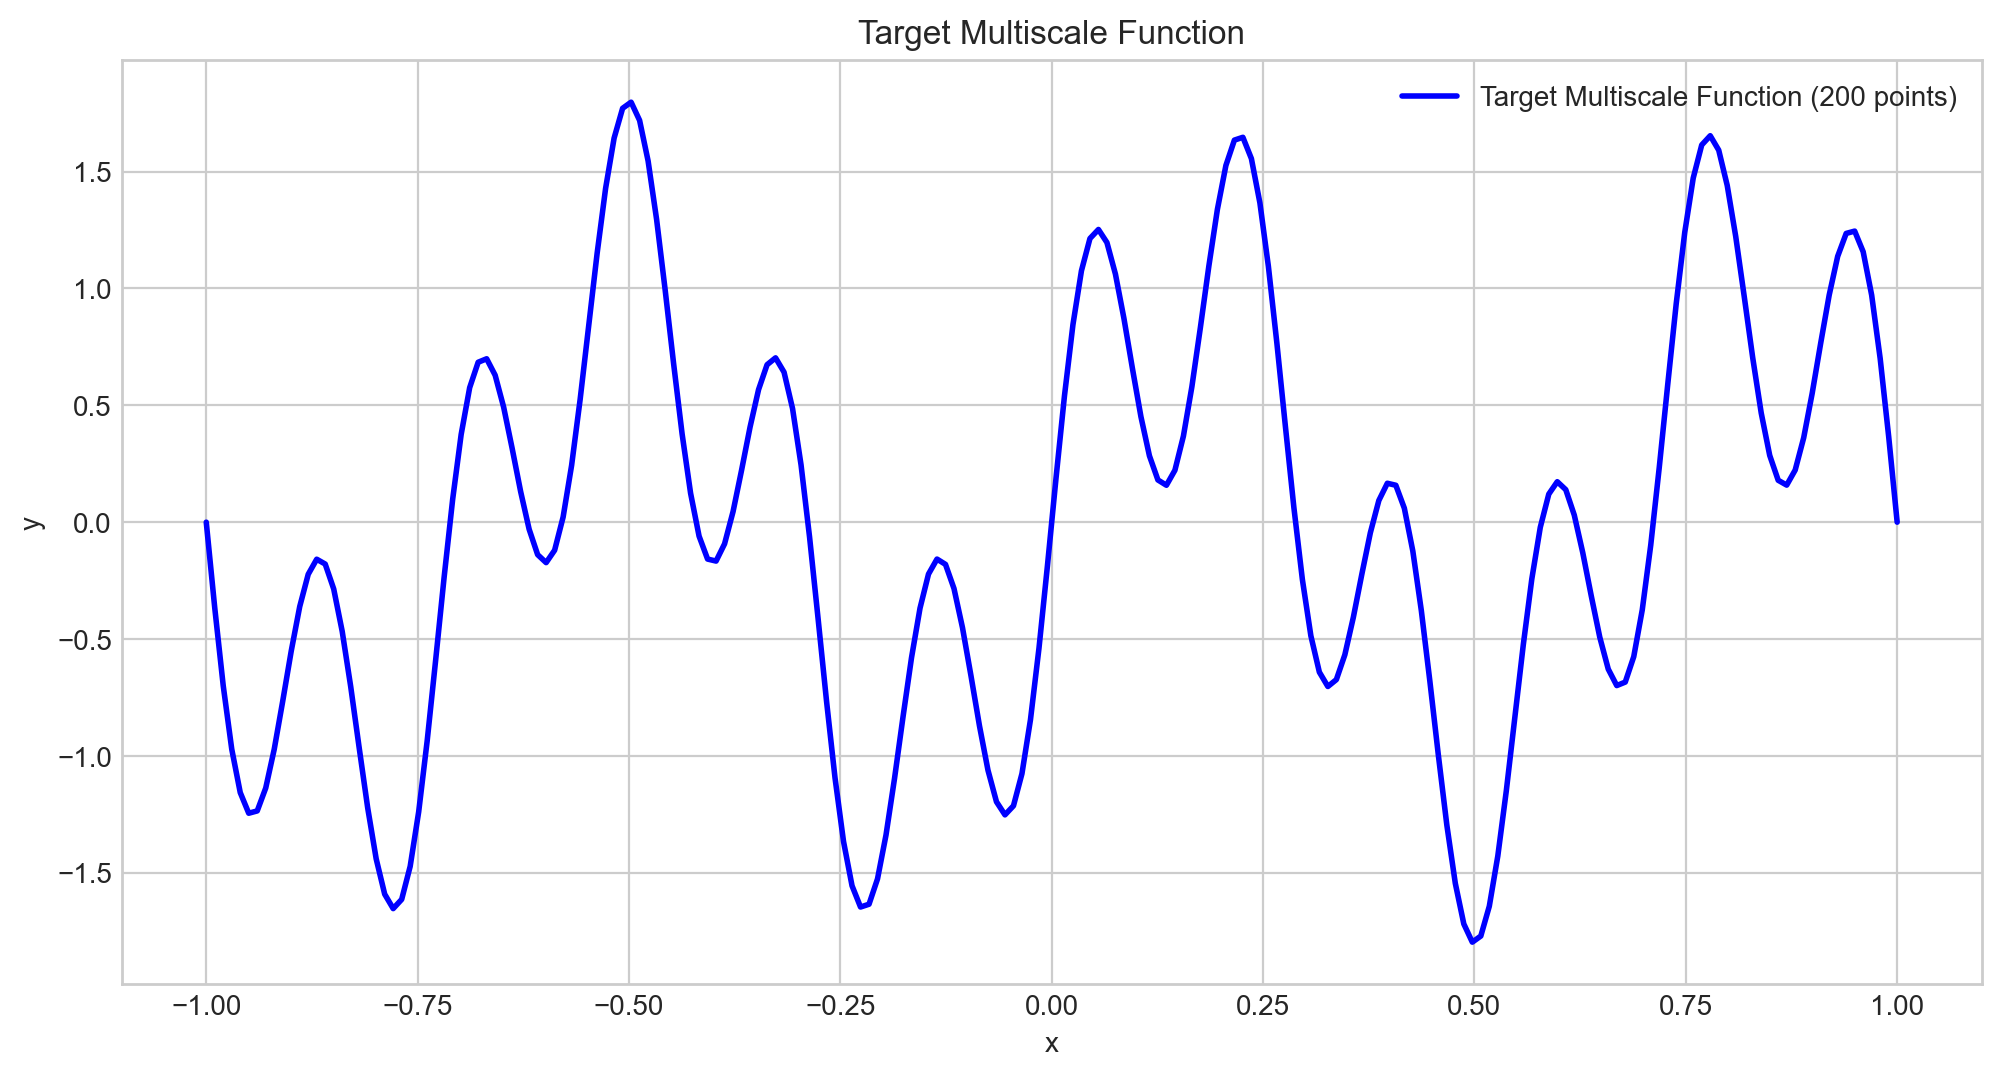

X_train shape: (200, 1), Y_train shape: (200, 1)


In [6]:
key_data_gen, key_sample = jax.random.split(key, 2)
key = key_data_gen 

N_TRAIN_SAMPLES = 200 # careful, too much could halt your computer

X_domain_min = -1.0
X_domain_max = 1.0

X_train = jnp.linspace(X_domain_min, X_domain_max, N_TRAIN_SAMPLES)[:, None]
Y_train = jnp.sin(3 * jnp.pi * X_train) + 0.8 * jnp.sin(11 * jnp.pi * X_train)

X_test = jnp.linspace(X_domain_min - 0.1, X_domain_max + 0.1, 400)[:, None] 
Y_test_true = jnp.sin(3 * jnp.pi * X_test) + 0.8 * jnp.sin(11 * jnp.pi * X_test)

INPUT_DIM = X_train.shape[1]
OUTPUT_DIM = Y_train.shape[1]

plt.figure(figsize=(12, 6))
plt.plot(X_train, Y_train, label=f'Target Multiscale Function ({N_TRAIN_SAMPLES} points)', color='blue', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.title('Target Multiscale Function')
plt.grid(True)
plt.show()

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")


Network Architecture: InputDim=1, HiddenLayers=2, HiddenWidth=1024, OutputDim=1
Layer widths for NTKAnalyzer: [1, 1024, 1024, 1]
Activation function: (<function _elementwise.<locals>.<lambda> at 0x31a60ed40>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x31a60efc0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x31a60f740>)


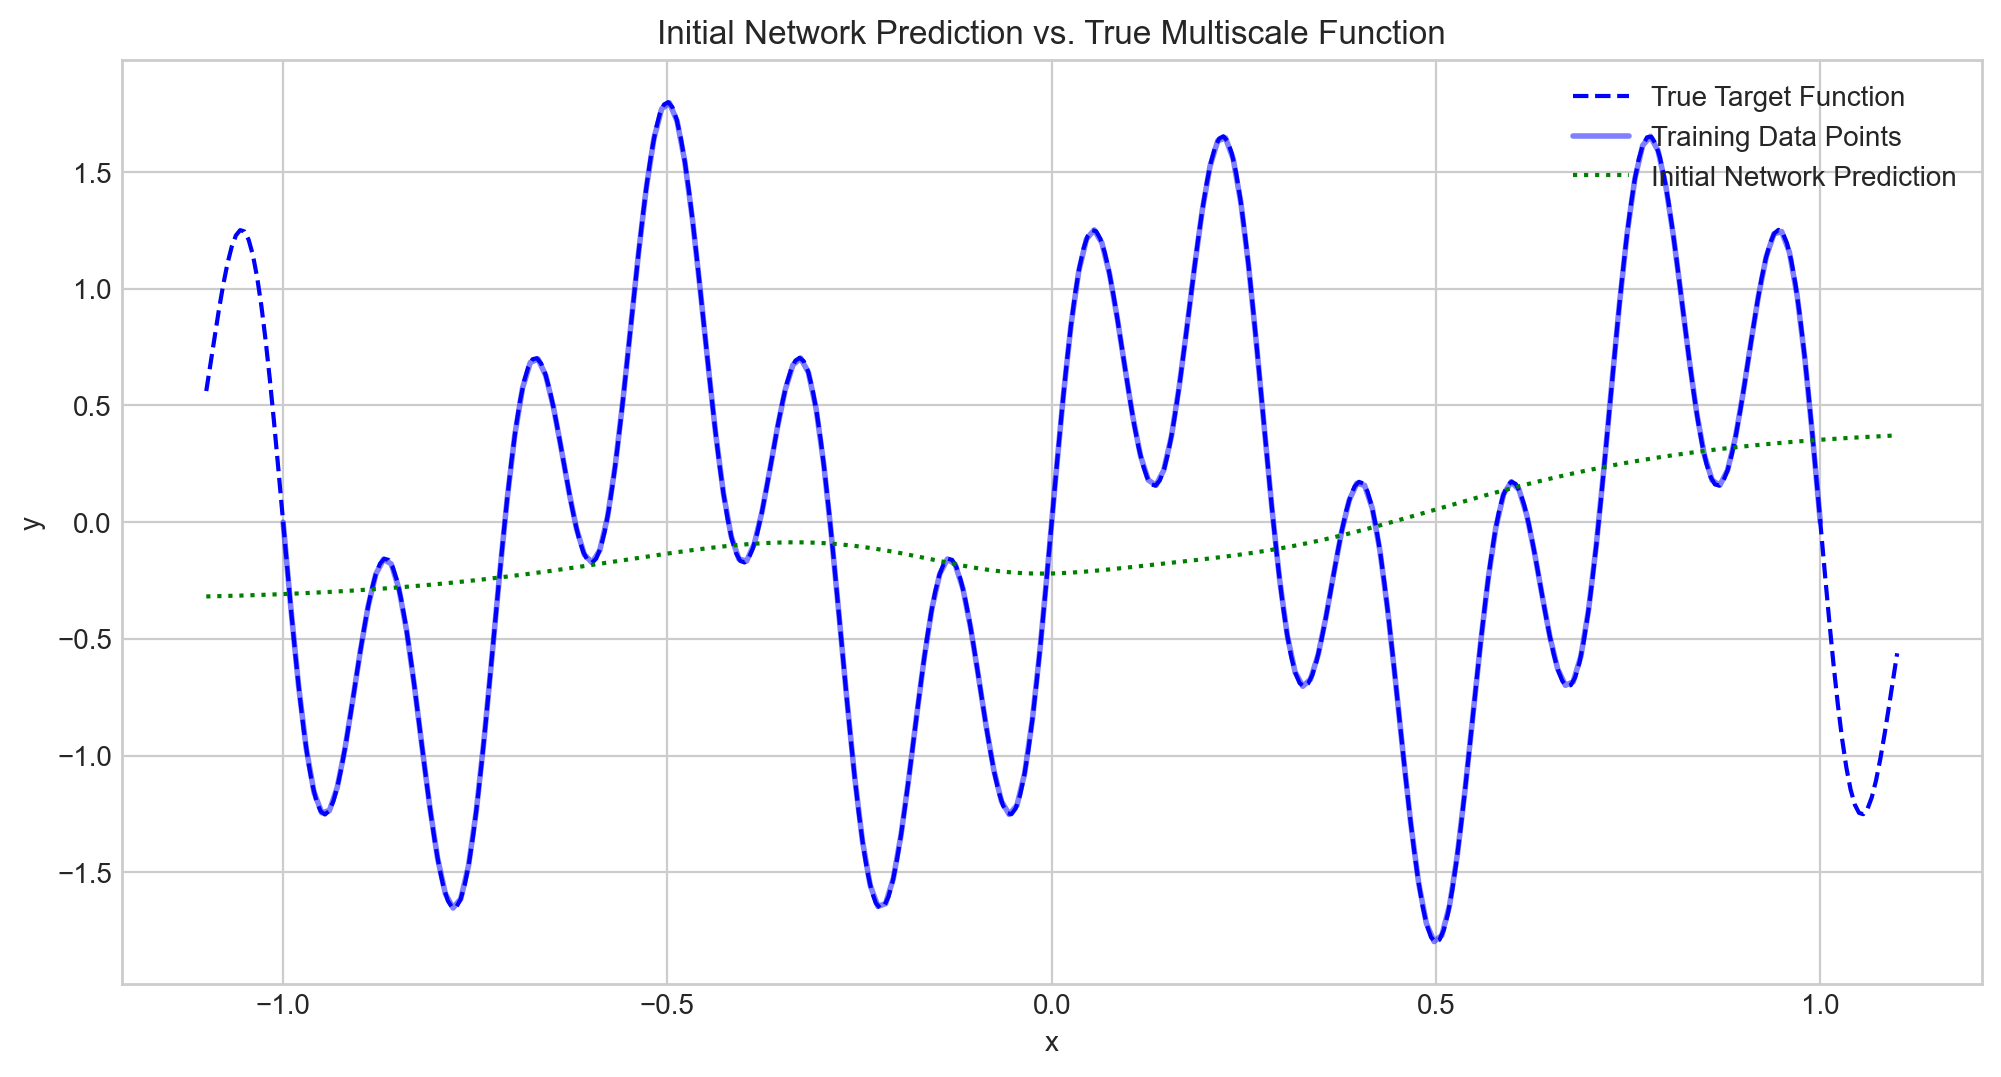

In [7]:
key, init_key = jax.random.split(key)

HIDDEN_LAYERS = 2      
HIDDEN_WIDTH = 1024     
ACTIVATION_FN_STAX = stax.Erf() 

# for init of weights
W_STD = 1.5            
B_STD = 0.05

init_fn, net_apply_fn, net_stax_kernel_fn = create_mlp_stax(
    depth=HIDDEN_LAYERS, 
    hidden_width=HIDDEN_WIDTH,
    output_dim=OUTPUT_DIM,
    activation_stax_fn=ACTIVATION_FN_STAX,
    W_std=W_STD,
    b_std=B_STD
)

layer_widths_spec = [INPUT_DIM] + [HIDDEN_WIDTH] * HIDDEN_LAYERS + [OUTPUT_DIM]

_, params_initial = init_fn(init_key, (-1, INPUT_DIM)) 

print(f"\nNetwork Architecture: InputDim={INPUT_DIM}, HiddenLayers={HIDDEN_LAYERS}, HiddenWidth={HIDDEN_WIDTH}, OutputDim={OUTPUT_DIM}")
print(f"Layer widths for NTKAnalyzer: {layer_widths_spec}")
print(f"Activation function: {ACTIVATION_FN_STAX}")

Y_pred_initial = net_apply_fn(params_initial, X_test)

plt.figure(figsize=(12, 6))
plt.plot(X_test, Y_test_true, label='True Target Function', color='blue', linestyle='--')
plt.plot(X_train, Y_train, label='Training Data Points', color='blue', alpha=0.5, linewidth=2) 
plt.plot(X_test, Y_pred_initial, label='Initial Network Prediction', color='green', linestyle=':')
plt.title('Initial Network Prediction vs. True Multiscale Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [23]:
import pandas as pd

ACTIVATION_FUNCTIONS = {
    "ReLU": stax.Relu(),
    "Sigmoid_like": stax.Sigmoid_like(),
    "Gelu": stax.Gelu()
}

CURRENT_ACTIVATION = "Gelu"

network_configurations = [
    # Group 1: Fixed Width, Varying Depth
    # W = 16
    {"name": "D1_W16",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/16 = 0.0625
    {"name": "D2_W16",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/16 = 0.125
    {"name": "D4_W16",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/16 = 0.25
    {"name": "D8_W16",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/16 = 0.5
    {"name": "D16_W16",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/16 = 1.0
    {"name": "D32_W16",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/16 = 2.0
    {"name": "D48_W16",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 48/16 = 3.0
    {"name": "D64_W16",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/16 = 4.0

    # W = 32
    {"name": "D1_W32",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/32 = 0.03125
    {"name": "D2_W32",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/32 = 0.0625
    {"name": "D3_W32",   "HIDDEN_LAYERS": 3,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 3/32 = 0.09375
    {"name": "D4_W32",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/32 = 0.125
    {"name": "D6_W32",   "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 6/32 = 0.1875
    {"name": "D8_W32",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/32 = 0.25
    {"name": "D10_W32",  "HIDDEN_LAYERS": 10,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 10/32 = 0.3125
    {"name": "D16_W32",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/32 = 0.5
    {"name": "D24_W32",  "HIDDEN_LAYERS": 24,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 24/32 = 0.75
    {"name": "D32_W32",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/32 = 1.0
    {"name": "D40_W32",  "HIDDEN_LAYERS": 40,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 40/32 = 1.25
    {"name": "D48_W32",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 48/32 = 1.5
    {"name": "D64_W32",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/32 = 2.0

    # W = 64
    {"name": "D1_W64",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/64 = 0.015625
    {"name": "D2_W64",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/64 = 0.03125
    {"name": "D3_W64",   "HIDDEN_LAYERS": 3,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 3/64 = 0.046875
    {"name": "D4_W64",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/64 = 0.0625
    {"name": "D6_W64",   "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 6/64 = 0.09375
    {"name": "D8_W64",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/64 = 0.125
    {"name": "D12_W64",  "HIDDEN_LAYERS": 12,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 12/64 = 0.1875
    {"name": "D16_W64",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/64 = 0.25
    {"name": "D24_W64",  "HIDDEN_LAYERS": 24,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 24/64 = 0.375
    {"name": "D32_W64",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/64 = 0.5
    {"name": "D48_W64",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 48/64 = 0.75
    {"name": "D64_W64",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/64 = 1.0
    {"name": "D80_W64",  "HIDDEN_LAYERS": 80,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 80/64 = 1.25
    {"name": "D96_W64",  "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 96/64 = 1.5

    # W = 128
    {"name": "D1_W128",  "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/128 = 0.0078125
    {"name": "D2_W128",  "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/128 = 0.015625
    {"name": "D4_W128",  "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/128 = 0.03125
    {"name": "D6_W128",  "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 6/128 = 0.046875
    {"name": "D8_W128",  "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/128 = 0.0625
    {"name": "D12_W128", "HIDDEN_LAYERS": 12,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 12/128 = 0.09375
    {"name": "D16_W128", "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/128 = 0.125
    {"name": "D32_W128", "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/128 = 0.25
    {"name": "D64_W128", "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/128 = 0.5
    {"name": "D96_W128", "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 96/128 = 0.75
    {"name": "D128_W128","HIDDEN_LAYERS": 128, "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 128/128 = 1.0

    # W = 256
    {"name": "D1_W256",  "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/256 = 0.00390625
    {"name": "D2_W256",  "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/256 = 0.0078125
    {"name": "D4_W256",  "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/256 = 0.015625
    {"name": "D8_W256",  "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/256 = 0.03125
    {"name": "D16_W256", "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/256 = 0.0625
    {"name": "D32_W256", "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/256 = 0.125
    {"name": "D64_W256", "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/256 = 0.25
    {"name": "D96_W256", "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 96/256 = 0.375
    {"name": "D192_W256","HIDDEN_LAYERS": 192, "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 192/256 = 0.75

    # Group 2: Fixed Depth, Varying Width
    # D = 1
    {"name": "D1_W512",  "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/512 = 0.001953125
    {"name": "D1_W1024", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/1024 = 0.0009765625
    {"name": "D1_W2048", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/2048 = 0.00048828125
    {"name": "D1_W4096", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/4096 = 0.000244140625

    # D = 2
    {"name": "D2_W512",  "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/512 = 0.00390625
    {"name": "D2_W1024", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/1024 = 0.001953125
    {"name": "D2_W2048", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/2048 = 0.0009765625
    {"name": "D2_W4096", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/4096 = 0.00048828125

    # D = 4
    {"name": "D4_W512",  "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/512 = 0.0078125
    {"name": "D4_W1024", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/1024 = 0.00390625
    {"name": "D4_W2048", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/2048 = 0.001953125
    {"name": "D4_W4096", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/4096 = 0.0009765625

    # D = 8
    {"name": "D8_W512",  "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/512 = 0.015625
    {"name": "D8_W1024", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/1024 = 0.0078125
    {"name": "D8_W2048", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/2048 = 0.00390625
    {"name": "D8_W4096", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/4096 = 0.001953125

    # D = 16
    {"name": "D16_W512", "HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 512, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/512 = 0.03125
    {"name": "D16_W1024","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/1024 = 0.015625
    {"name": "D16_W2048","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/2048 = 0.0078125
    {"name": "D16_W4096","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/4096 = 0.00390625

    # D = 32
    {"name": "D32_W512", "HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/512 = 0.0625
    {"name": "D32_W1024","HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/1024 = 0.03125
    {"name": "D32_W2048","HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/2048 = 0.015625
]

# Choose a single data point from X_train (defined in Cell 2)
x_single_point_for_analysis = X_train[0:1, :] # Shape (1, INPUT_DIM)
x_norm_sq = jnp.linalg.norm(x_single_point_for_analysis.squeeze())**2 
n0 = INPUT_DIM # Input dimension

# For verifying Theorem 2
y_star_for_sgd_step = Y_train[0:1, :] # Target for the chosen x_single_point
learning_rate_sgd = 1e-3 # Learning rate for the single SGD step

num_initializations_for_verification = 100

print(f"Will analyze {len(network_configurations)} network configurations.")
print(f"Using x_single_point: {x_single_point_for_analysis.squeeze()}, ||x||^2: {x_norm_sq:.4f}")
print(f"Input dimension n0 (INPUT_DIM): {n0}")
print(f"Number of random initializations for averaging: {num_initializations_for_verification}")

# List to store results from all configurations
relu_result = []

# Main PRNG key for this loop of experiments
main_exp_key = jax.random.PRNGKey(789)

def mse_loss_single_point_fn(params_current, x_batch, y_batch, apply_fn_local):
    y_pred = apply_fn_local(params_current, x_batch)
    if y_pred.shape != y_batch.shape and y_pred.shape[-1] == y_batch.shape[-1]:
        y_pred = y_pred.reshape(y_batch.shape)
    return 0.5 * jnp.sum((y_pred - y_batch)**2) # Sum for scalar loss

Will analyze 78 network configurations.
Using x_single_point: -1.0, ||x||^2: 1.0000
Input dimension n0 (INPUT_DIM): 1
Number of random initializations for averaging: 100


## Main loop

If you don't want to run this (which takes time), skip this cell and move to [Loading existing restuls](#loading-existing-results).

In [24]:
EPOCHS_FULL_TRAINING = 1000 
LEARNING_RATE_FULL_TRAINING = 1e-3
BATCH_SIZE_FULL_TRAINING = 128 
TRACK_NTK_EVERY_EPOCHS = EPOCHS_FULL_TRAINING // 20 # Track NTK at these epoch intervals
if TRACK_NTK_EVERY_EPOCHS == 0:
    TRACK_NTK_EVERY_EPOCHS = 1

def mse_loss_for_training(params_current, x_batch, y_batch, apply_fn_local):
    y_pred = apply_fn_local(params_current, x_batch)
    if hasattr(y_batch, 'shape') and hasattr(y_pred, 'shape') and y_pred.shape != y_batch.shape:
        if y_pred.ndim == y_batch.ndim + 1 and y_pred.shape[-1] == 1:
            y_pred = y_pred.squeeze(axis=-1)
        elif y_batch.ndim == y_pred.ndim + 1 and y_batch.shape[-1] == 1:
             y_batch = y_batch.squeeze(axis=-1)

        if y_pred.shape != y_batch.shape:
            y_pred = y_pred.reshape(y_batch.shape) # Fallback to original reshape
    return jnp.mean((y_pred - y_batch)**2)

results_ntk_during_full_training = []
main_train_loop_key = jax.random.PRNGKey(1234)

print(f"--- Starting NTK Tracking during Full Training ---")
print(f"Training for {EPOCHS_FULL_TRAINING} epochs, BATCH_SIZE={BATCH_SIZE_FULL_TRAINING}")
print(f"NTK (K(x,x) at fixed point) will be tracked every {TRACK_NTK_EVERY_EPOCHS} epochs.")

for config_idx, config in enumerate(network_configurations):
    print(f"\n--- Processing Configuration {config_idx+1}/{len(network_configurations)}: {config['name']} ---")
    config_start_time = time.time()

    # Network setup from configuration
    current_hidden_layers = config["HIDDEN_LAYERS"]
    current_hidden_width = config["HIDDEN_WIDTH"]
    current_activation_fn = config["ACTIVATION_FN_STAX"]
    current_w_std = config["W_STD"]
    current_b_std = config["B_STD"]

    init_fn_config, apply_fn_config, _, layer_widths_config = create_mlp_stax_2(
        depth_hidden=current_hidden_layers,
        hidden_width=current_hidden_width,
        output_dim=OUTPUT_DIM, 
        input_dim=INPUT_DIM,  
        activation_stax_fn=current_activation_fn,
        W_std=current_w_std,
        b_std=current_b_std
    )

    temp_beta_val = None
    if layer_widths_config and len(layer_widths_config) > 2:
        hidden_widths_conf = layer_widths_config[1:-1]
        if hidden_widths_conf:
            temp_beta_val = sum(1.0 / w for w in hidden_widths_conf if w > 0)
    beta_print_str = f"{temp_beta_val:.4f}" if temp_beta_val is not None else "N/A"
    print(f"  Config: {config['name']}, Beta={beta_print_str}")

    # Initialize parameters
    main_train_loop_key, init_key = jax.random.split(main_train_loop_key)
    _, params_initial_training = init_fn_config(init_key, (-1, INPUT_DIM))

    # Optimizer setup
    optimizer = optax.adam(LEARNING_RATE_FULL_TRAINING)
    opt_state_initial_training = optimizer.init(params_initial_training)

    # Loss function specific to this network's apply_fn
    loss_fn_for_grad_training = jax.tree_util.Partial(mse_loss_for_training, apply_fn_local=apply_fn_config)

    @jax.jit
    def train_step_jit(params_current, opt_state_current, x_batch, y_batch):
        loss_value, grads = jax.value_and_grad(loss_fn_for_grad_training)(params_current, x_batch, y_batch)
        updates, opt_state_new = optimizer.update(grads, opt_state_current, params_current)
        params_new = optax.apply_updates(params_current, updates)
        return params_new, opt_state_new, loss_value

    # NTK Tracking
    ntk_evolution_for_this_config = []
    params_current_training = params_initial_training
    opt_state_current_training = opt_state_initial_training

    # Instantiate NTKAnalyzer (can be done once per config)
    # The params used for instantiation don't matter if we always use params_override
    analyzer_for_training = NTKAnalyzer(
        apply_fn=apply_fn_config,
        params=params_initial_training, # Placeholder, will be overridden
        depth=current_hidden_layers,
        widths=layer_widths_config
    )

    # --- Track NTK at Epoch 0 (before training) ---
    diag_val_obj_epoch0 = analyzer_for_training.get_ntk_diagonal_per_output(x_single_point_for_analysis, params_override=params_current_training)
    k_xx_epoch0_val = jnp.nan # Default
    if diag_val_obj_epoch0 is not None:
        k_xx_epoch0_val = diag_val_obj_epoch0[0, 0].item()
    ntk_evolution_for_this_config.append({"epoch": 0, "k_xx": k_xx_epoch0_val, "loss": jnp.nan}) # Loss before training
    print(f"  Epoch 0: K(x,x) = {k_xx_epoch0_val:.6e}")

    # --- Training Loop ---
    num_batches_per_epoch = N_TRAIN_SAMPLES // BATCH_SIZE_FULL_TRAINING if N_TRAIN_SAMPLES > BATCH_SIZE_FULL_TRAINING and BATCH_SIZE_FULL_TRAINING > 0 else 1

    for epoch in range(EPOCHS_FULL_TRAINING):
        main_train_loop_key, perm_key_epoch = jax.random.split(main_train_loop_key)
        epoch_loss_sum = 0.0
        
        if BATCH_SIZE_FULL_TRAINING > 0 and BATCH_SIZE_FULL_TRAINING < N_TRAIN_SAMPLES:
            perm = jax.random.permutation(perm_key_epoch, N_TRAIN_SAMPLES)
            shuffled_X_train = X_train[perm]
            shuffled_Y_train = Y_train[perm]
            
            for i_batch in range(num_batches_per_epoch):
                start = i_batch * BATCH_SIZE_FULL_TRAINING
                end = start + BATCH_SIZE_FULL_TRAINING
                x_batch = shuffled_X_train[start:end]
                y_batch = shuffled_Y_train[start:end]
                params_current_training, opt_state_current_training, loss_val_batch = train_step_jit(params_current_training, opt_state_current_training, x_batch, y_batch)
                epoch_loss_sum += loss_val_batch
            current_epoch_avg_loss = (epoch_loss_sum / num_batches_per_epoch).item()
        else: # Full batch
            params_current_training, opt_state_current_training, loss_val_epoch = train_step_jit(params_current_training, opt_state_current_training, X_train, Y_train)
            current_epoch_avg_loss = loss_val_epoch.item()

        # --- Track NTK Periodically ---
        if (epoch + 1) % TRACK_NTK_EVERY_EPOCHS == 0 or (epoch + 1) == EPOCHS_FULL_TRAINING:
            diag_val_obj_current_epoch = analyzer_for_training.get_ntk_diagonal_per_output(x_single_point_for_analysis, params_override=params_current_training)
            k_xx_current_epoch_val = jnp.nan
            if diag_val_obj_current_epoch is not None:
                k_xx_current_epoch_val = diag_val_obj_current_epoch[0, 0].item()
            ntk_evolution_for_this_config.append({"epoch": epoch + 1, "k_xx": k_xx_current_epoch_val, "loss": current_epoch_avg_loss})
            if (epoch + 1) % (TRACK_NTK_EVERY_EPOCHS * 5) == 0 or (epoch + 1) == EPOCHS_FULL_TRAINING : # Print less frequently
                 print(f"  Epoch {epoch+1}/{EPOCHS_FULL_TRAINING}: Loss = {current_epoch_avg_loss:.6f}, K(x,x) = {k_xx_current_epoch_val:.6e}")
    
    # Store results for this configuration
    config_run_result = {
        "config_name": config["name"],
        "beta": temp_beta_val,
        "hidden_layers": current_hidden_layers,
        "hidden_width": current_hidden_width,
        "activation": config["ACTIVATION_NAME"],
        "final_loss": current_epoch_avg_loss,
        "ntk_evolution_ Kxx_at_fixed_point": ntk_evolution_for_this_config
    }
    results_ntk_during_full_training.append(config_run_result)
    print(f"  Finished config {config['name']} in {time.time() - config_start_time:.2f}s. Final Loss: {current_epoch_avg_loss:.6f}")

# --- Convert to DataFrame and Display ---
ntk_full_training_df = pd.DataFrame(results_ntk_during_full_training)
print("\n--- Summary of NTK Evolution During Full Training ---")
display(ntk_full_training_df)

--- Starting NTK Tracking during Full Training ---
Training for 1000 epochs, BATCH_SIZE=128
NTK (K(x,x) at fixed point) will be tracked every 50 epochs.

--- Processing Configuration 1/78: D1_W16 ---
  Config: D1_W16, Beta=0.0625
  Epoch 0: K(x,x) = 2.484874e+00
  Epoch 250/1000: Loss = 0.731070, K(x,x) = 2.567794e+00
  Epoch 500/1000: Loss = 0.796492, K(x,x) = 2.644791e+00
  Epoch 750/1000: Loss = 0.866874, K(x,x) = 2.647649e+00
  Epoch 1000/1000: Loss = 0.787722, K(x,x) = 2.652292e+00
  Finished config D1_W16 in 0.87s. Final Loss: 0.787722

--- Processing Configuration 2/78: D2_W16 ---
  Config: D2_W16, Beta=0.1250
  Epoch 0: K(x,x) = 1.628004e+00
  Epoch 250/1000: Loss = 0.729671, K(x,x) = 2.513210e+00
  Epoch 500/1000: Loss = 0.808933, K(x,x) = 2.507523e+00
  Epoch 750/1000: Loss = 0.736406, K(x,x) = 2.591098e+00
  Epoch 1000/1000: Loss = 0.801112, K(x,x) = 2.558677e+00
  Finished config D2_W16 in 0.75s. Final Loss: 0.801112

--- Processing Configuration 3/78: D4_W16 ---
  Config: 

,config_name,beta,hidden_layers,hidden_width,activation,final_loss,ntk_evolution_ Kxx_at_fixed_point
0,D1_W16,0.062500,1,16,Gelu,0.787722,"[{'epoch': 0, 'k_xx': 2.4848735332489014, 'los..."
1,D2_W16,0.125000,2,16,Gelu,0.801112,"[{'epoch': 0, 'k_xx': 1.6280035972595215, 'los..."
2,D4_W16,0.250000,4,16,Gelu,0.306660,"[{'epoch': 0, 'k_xx': 6.939463138580322, 'loss..."
3,D8_W16,0.500000,8,16,Gelu,0.288048,"[{'epoch': 0, 'k_xx': 1.0581849813461304, 'los..."
4,D16_W16,1.000000,16,16,Gelu,0.085185,"[{'epoch': 0, 'k_xx': 3.5450935683911666e-05, ..."
...,...,...,...,...,...,...,...
73,D16_W2048,0.007812,16,2048,Gelu,0.000076,"[{'epoch': 0, 'k_xx': 0.39083459973335266, 'lo..."
74,D16_W4096,0.003906,16,4096,Gelu,0.009156,"[{'epoch': 0, 'k_xx': 0.7036123275756836, 'los..."
75,D32_W512,0.062500,32,512,Gelu,0.082692,"[{'epoch': 0, 'k_xx': 1.6756486729718745e-05, ..."
76,D32_W1024,0.031250,32,1024,Gelu,0.004123,"[{'epoch': 0, 'k_xx': 3.467904207354877e-06, '..."


In [25]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created directory: {output_directory}")

base_filename = "gelu-ntk-during-training.dill.pkl"
pickle_filename = os.path.join(output_directory, base_filename)

ntk_full_training_df = pd.DataFrame(results_ntk_during_full_training)

with open(pickle_filename, 'wb') as f:
    dill.dump(ntk_full_training_df, f)
print(f"Results saved to {pickle_filename}")

Results saved to data/training/gelu-ntk-during-training.dill.pkl


## Loading existing results

In [8]:
base_filename = "relu-ntk-during-training.dill.pkl"
pickle_filename = os.path.join(output_directory, base_filename)

loaded_results_df = None
try:
    with open(pickle_filename, 'rb') as f:
        loaded_results_df = dill.load(f)
except Exception as e:
    print(e)

ntk_full_training_df = loaded_results_df
display(ntk_full_training_df)

,config_name,beta,hidden_layers,hidden_width,activation,final_loss,ntk_evolution_ Kxx_at_fixed_point
0,D1_W16,0.062500,1,16,ReLU,0.775402,"[{'epoch': 0, 'k_xx': 2.6252963542938232, 'los..."
1,D2_W16,0.125000,2,16,ReLU,0.775402,"[{'epoch': 0, 'k_xx': 2.022085189819336, 'loss..."
2,D4_W16,0.250000,4,16,ReLU,0.775405,"[{'epoch': 0, 'k_xx': 8.210689544677734, 'loss..."
3,D8_W16,0.500000,8,16,ReLU,0.775402,"[{'epoch': 0, 'k_xx': 7.120701789855957, 'loss..."
4,D16_W16,1.000000,16,16,ReLU,0.775402,"[{'epoch': 0, 'k_xx': 0.026381980627775192, 'l..."
...,...,...,...,...,...,...,...
73,D16_W2048,0.007812,16,2048,ReLU,0.775402,"[{'epoch': 0, 'k_xx': 19.854320526123047, 'los..."
74,D16_W4096,0.003906,16,4096,ReLU,0.775402,"[{'epoch': 0, 'k_xx': 18.031496047973633, 'los..."
75,D32_W512,0.062500,32,512,ReLU,0.775402,"[{'epoch': 0, 'k_xx': 23.050077438354492, 'los..."
76,D32_W1024,0.031250,32,1024,ReLU,0.775402,"[{'epoch': 0, 'k_xx': 21.4324893951416, 'loss'..."


## Plotting results

### How does NTK evolve over epochs for a few representative network configurations

The graph illustrates the evolution of $ K(x, x) $ during training over 1000 epochs for various network configurations, plotted on a log scale. To read the graph, observe the normalized $ K(x, x) $ values (divided by the initial value at epoch 0) for each configuration, where each line represents a different network setup identified by its configuration name and corresponding $ \beta $ -> higher $ \beta $ values indicate deeper or narrower networks, and the steepness or stability of the line reflects the degree of NTK evolution, with significant changes suggesting feature learning beyond the lazy training regime.

Up to the first 7 configurations are selected, plus the middle configuration (if more than 2 exist) and the last configuration, ensuring a diverse range of \( \beta \) values (e.g., 'D1_W16', 'D64_W16', 'D1_W4096', etc., as printed). Duplicates are removed using `list(set(configs_to_plot))`, resulting in a total of 9 unique configurations being selected for plotting.

Selected configurations for epoch-wise K(x,x) plots: ['D1_W2048', 'D1_W16', 'D2_W4096', 'D2_W2048', 'D4_W4096', 'D1_W1024', 'D1_W512', 'D64_W16', 'D1_W4096']


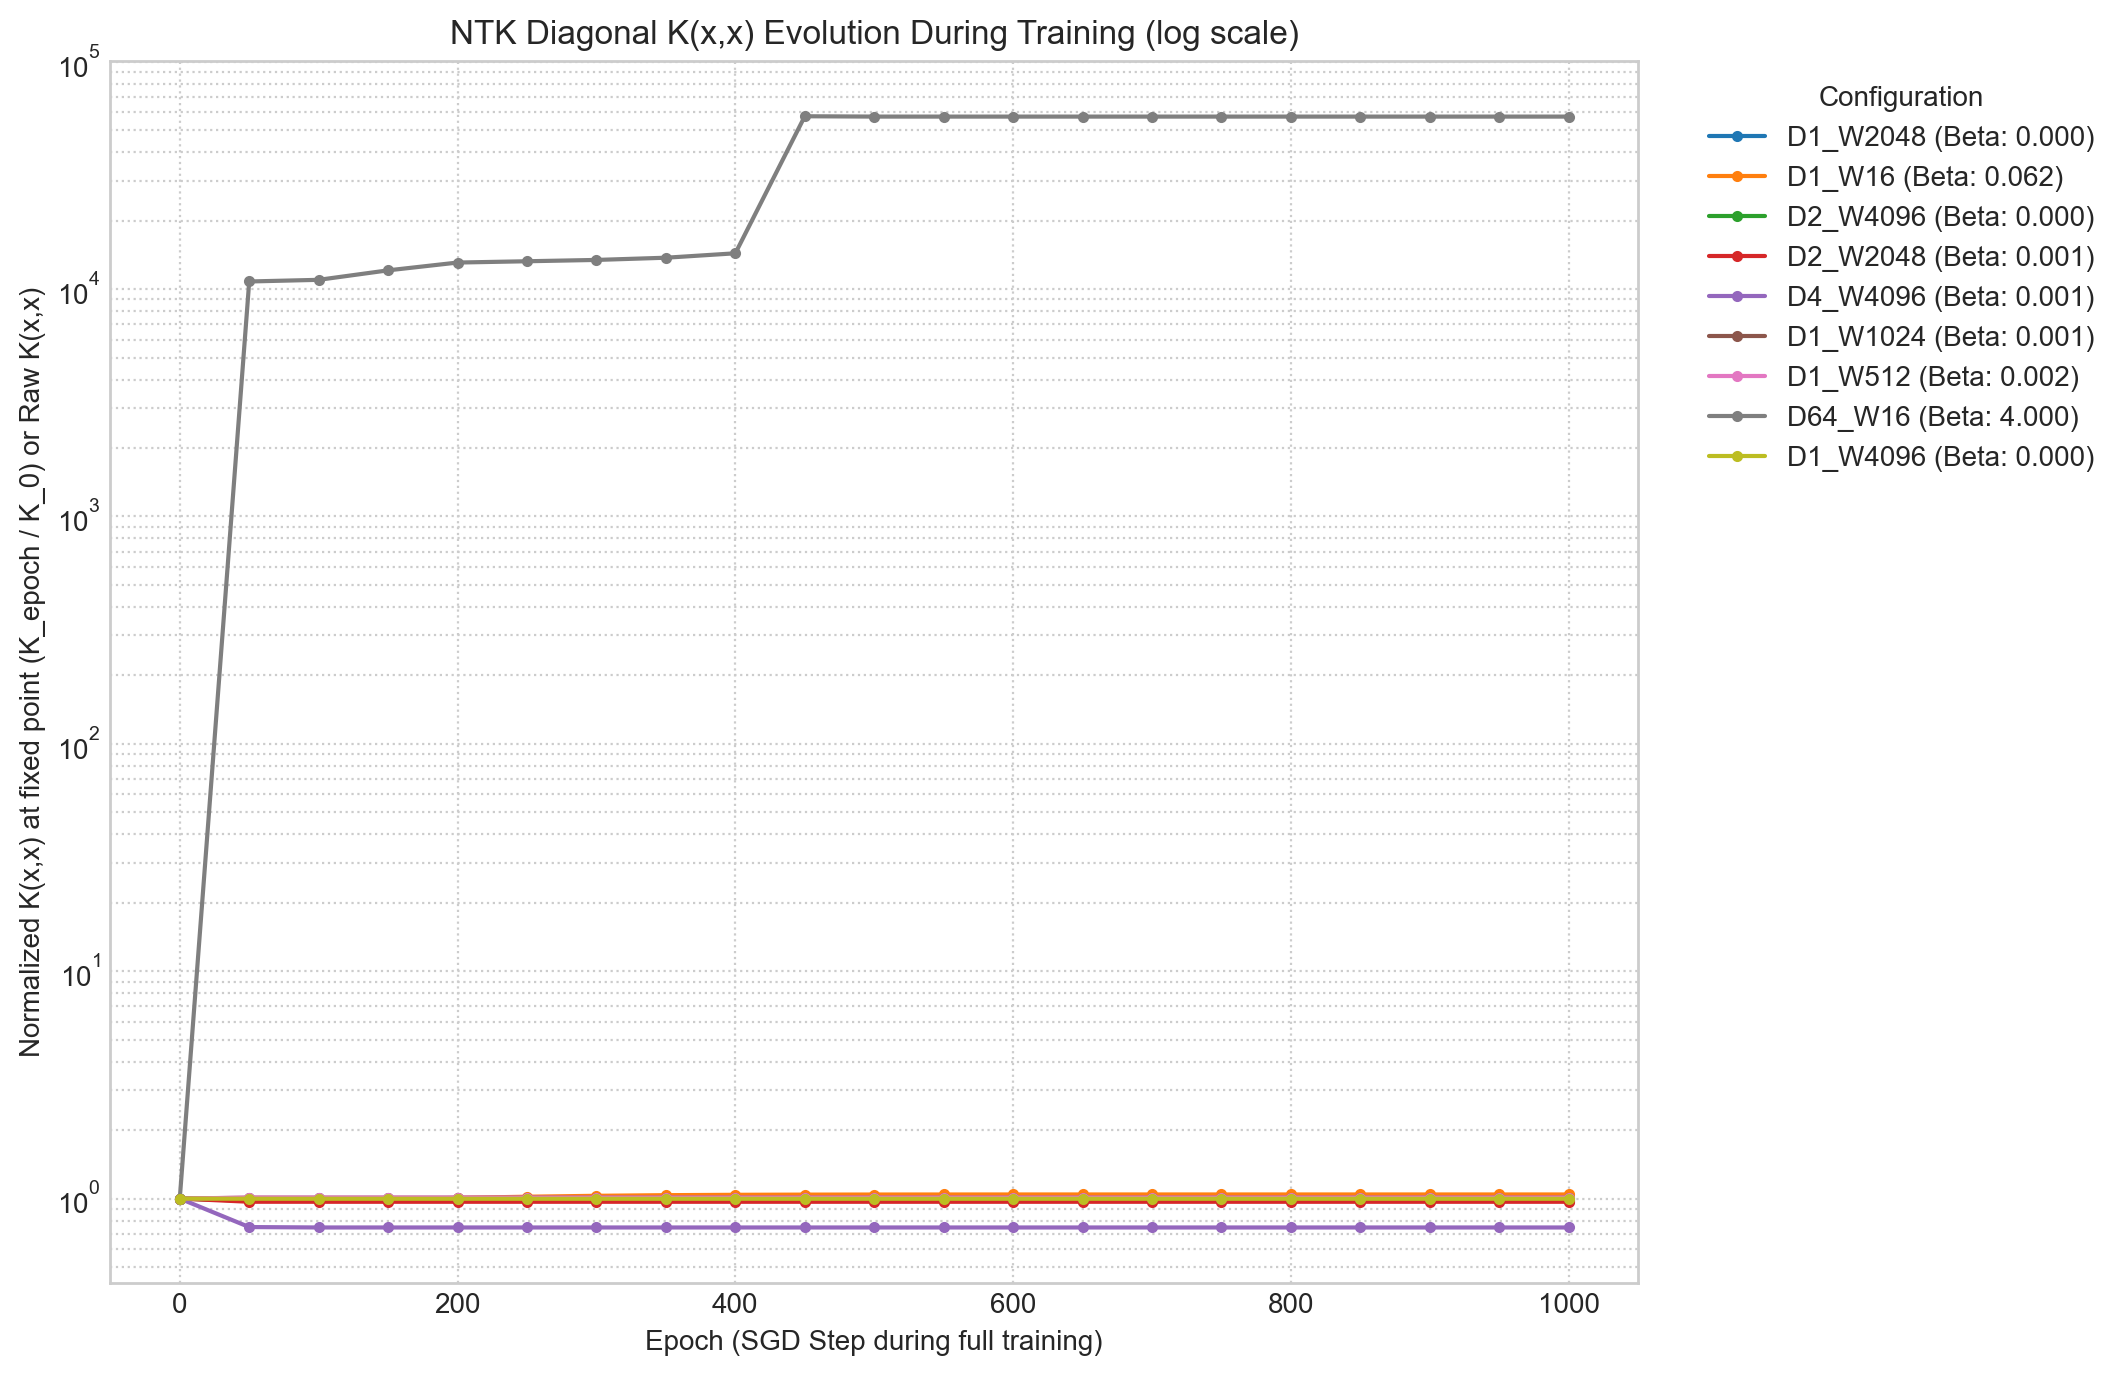

In [12]:
number_of_config_to_analyze = 7
configs_to_plot = []
sorted_df_for_selection = ntk_full_training_df.dropna(subset=['beta']).sort_values(by='beta')
if len(sorted_df_for_selection) > 0:
    for i in range(number_of_config_to_analyze):
        configs_to_plot.append(sorted_df_for_selection.iloc[i]['config_name'])
if len(sorted_df_for_selection) > 2:
    configs_to_plot.append(sorted_df_for_selection.iloc[len(sorted_df_for_selection)//2]['config_name'])
    configs_to_plot.append(sorted_df_for_selection.iloc[-1]['config_name'])
elif len(sorted_df_for_selection) > 1: 
    configs_to_plot.append(sorted_df_for_selection.iloc[-1]['config_name'])

configs_to_plot = list(set(configs_to_plot))

print(f"Selected configurations for epoch-wise K(x,x) plots: {configs_to_plot}")

plt.figure(figsize=(12, 7))
plot_count = 0
for config_name_to_plot in configs_to_plot:
    # Find the row for this config
    config_row_series = ntk_full_training_df[ntk_full_training_df['config_name'] == config_name_to_plot]
    if config_row_series.empty:
        print(f"Warning: Config '{config_name_to_plot}' not found in results.")
        continue
    
    config_data = config_row_series.iloc[0]
    
    evolution_data = config_data.get("ntk_evolution_ Kxx_at_fixed_point", [])
    if not evolution_data or not isinstance(evolution_data, list):
        print(f"No NTK evolution data or invalid format for {config_name_to_plot}")
        continue
        
    df_evo = pd.DataFrame(evolution_data)
    df_evo = df_evo.dropna(subset=['epoch', 'k_xx']) 

    if df_evo.empty or 'k_xx' not in df_evo.columns or 'epoch' not in df_evo.columns:
        print(f"Not enough valid data points for {config_name_to_plot} after dropping NaNs or missing columns.")
        continue
    
    # Normalize K(x,x) by its initial value (at epoch 0) for better comparison across different scales
    k_initial_series = df_evo[df_evo['epoch'] == 0]['k_xx']
    if not k_initial_series.empty:
        k_initial = k_initial_series.iloc[0]
        if k_initial != 0 and not pd.isna(k_initial):
            df_evo['k_xx_normalized'] = df_evo['k_xx'] / k_initial
            plt.plot(df_evo["epoch"], df_evo["k_xx_normalized"], marker='.', linestyle='-',
                     label=f"{config_data.get('config_name', 'Unknown')} (Beta: {config_data.get('beta', 'N/A'):.3f})")
            plot_count += 1
        else:
            print(f"Initial K(x,x) is zero or NaN for {config_name_to_plot}, plotting raw K(x,x).")
            plt.plot(df_evo["epoch"], df_evo["k_xx"], marker='.', linestyle='-',
                     label=f"{config_name_to_plot} (Beta: {config_data.get('beta', 'N/A'):.3f}) - Raw")
            plot_count += 1

    else:
        print(f"No K(x,x) data at epoch 0 for {config_name_to_plot}, plotting raw K(x,x).")
        plt.plot(df_evo["epoch"], df_evo["k_xx"], marker='.', linestyle='-',
                 label=f"{config_name_to_plot} (Beta: {config_data.get('beta', 'N/A'):.3f}) - Raw")
        plot_count +=1


plt.xlabel("Epoch (SGD Step during full training)")
plt.ylabel("Normalized K(x,x) at fixed point (K_epoch / K_0) or Raw K(x,x)")
plt.title(f"NTK Diagonal K(x,x) Evolution During Training (log scale)")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', title="Configuration")
plt.grid(True, which="both", linestyle=':')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()